In [1]:
from helper import print_frame
import numpy as np
from moviepy.editor import *

VID_FILE = 'omniverse.mp4'
AUD_FILE = 'omniverse_drums.wav'

### Pseudo Logic:
    video_list = []
    for split_time in split_times:
        clip = next(clips)
    
        while len(clip) < split_len:
            clip = next(clips)
        
        video_list += [clip[:split_len]]
       
    clip_list2vid(video_list)

### TODO:
- Create clip list
- Display audio waveforms
- Create tool to find best audio split points

### Ideas:
- Change frame changed threshold with variation in audio amplitude?

### Potentionally Useful Functions
- clip.get_frame(time)
- clip.ipython_display(width=240)

In [2]:
video = VideoFileClip(VID_FILE).subclip(0, 30)

In [3]:
print('Frames/Second:', video.reader.fps)
print('Frame Count:', video.reader.nframes)
print('Video Length:', video.duration)

Frames/Second: 25.0
Frame Count: 7826
Video Length: 30


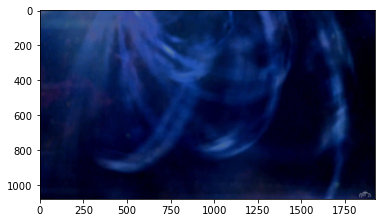

In [4]:
print_frame(video.get_frame(np.random.randint(0, video.duration)))

In [5]:
def scene_changed(prev_frame, frame, delta_thresh=30):
    delta = abs(np.mean(prev_frame) - np.mean(frame))
    
    if delta > delta_thresh:
        return True
    return False

# Split Video In To Clips

In [24]:
def split_video(video, skip_cnt=10, max_clips=0, print_split_frames=False, print_cmp_frames=False):
    clip_cnt = 0      # Number of clips created from video
    start_time = 0    # time in seconds from video where current clip starts
    clips = []        # list of subclips of video file created by video split

    prev_frame = video.get_frame(0) # Initialize previous frame
    
    for i, (time, frame) in enumerate(video.iter_frames(with_times=True)):

        if i % skip_cnt == 0:
            if print_cmp_frames:
                print_frame(np.append(prev_frame, frame, axis=1))

            if i > 0: # Skip first frame
                if start_time != stop_time and scene_changed(prev_frame, frame, delta_thresh=20):
                    if print_split_frames:
                        print_frame(prev_frame)

                    clips += [video.subclip(start_time, stop_time)]

                    start_time = time

                    clip_cnt += 1

            prev_frame = frame.copy()
            stop_time = time

            # Exit when we have the number of clips requested
            if max_clips != 0 and clip_cnt > max_clips:
                break
    return clips

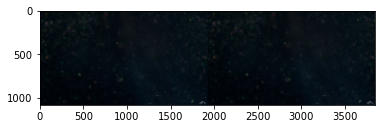

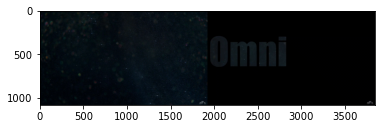

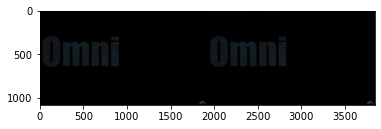

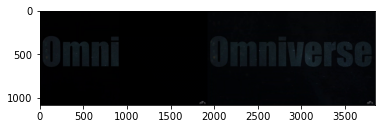

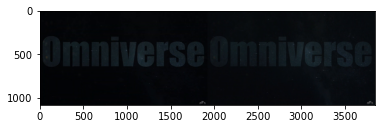

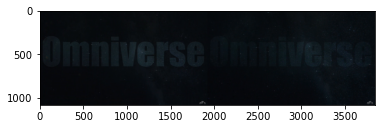

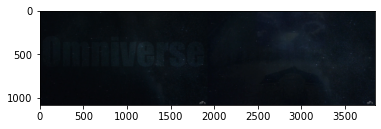

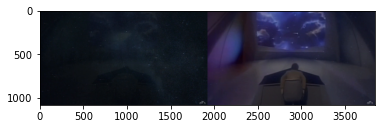

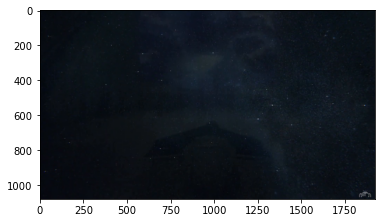

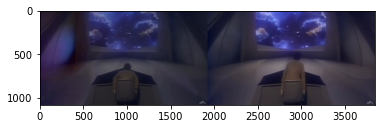

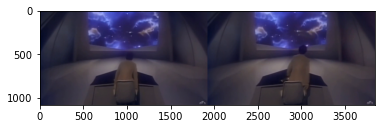

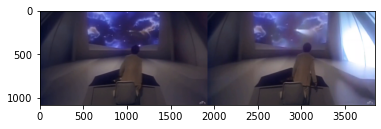

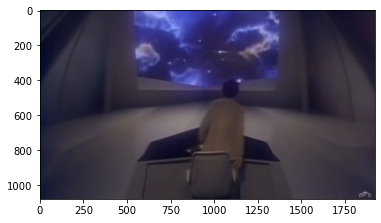

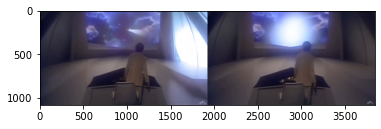

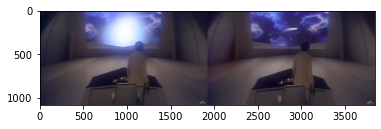

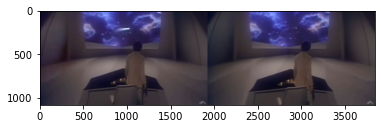

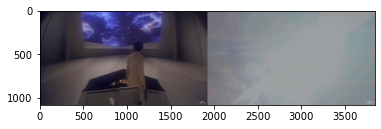

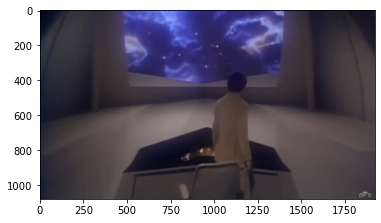

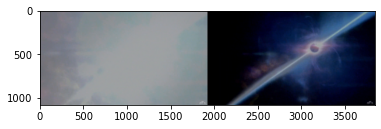

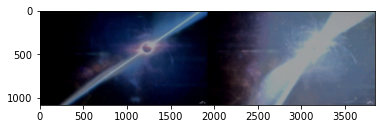

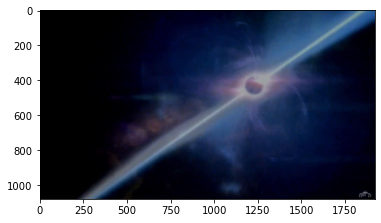

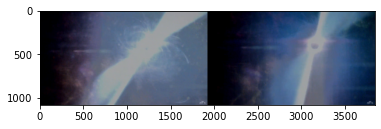

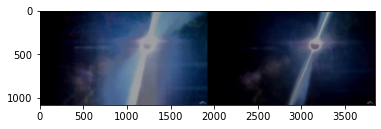

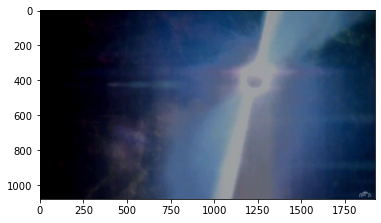

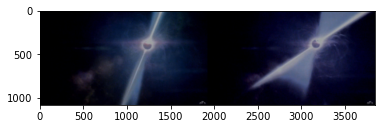

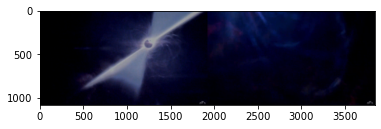

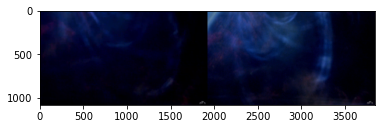

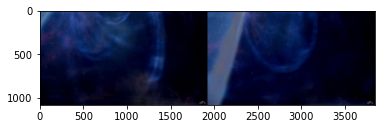

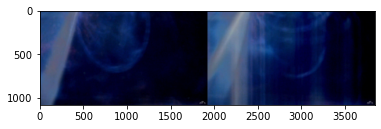

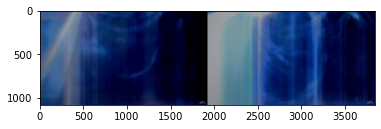

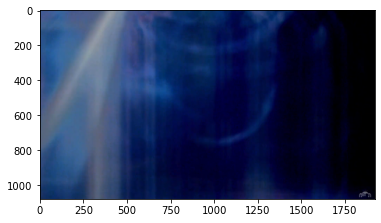

In [21]:
clips = split_video(video, max_clips=5)

In [23]:
clips[2].ipython_display(width=400)

t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# Audio

In [130]:
import wave
import pyaudio

In [265]:
def open_stream(audio_file, CHUNK_MUL=1):
    CHUNK = 1024*CHUNK_MUL
    
    wf = wave.open(audio_file, 'rb')
    RATE = wf.getframerate()
    FPS = RATE / CHUNK

    p = pyaudio.PyAudio()

    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=RATE,
                    output=True)
    
    return stream, wf, CHUNK, RATE

def get_audio_data():
    stream, wf, CHUNK, RATE = open_stream(AUD_FILE) 
    
    cnt = 0
    while True:
        # Read next frame
        data = wf.readframes(CHUNK)
        if len(data) < CHUNK:
            break

        data_int = np.frombuffer(data, dtype=np.int32) # Read bytes to int
        data_int = np.resize(data_int, (1, CHUNK)) # Handle final CHUNK where size might be less than CHUNK size

        if cnt == 0:
            all_data = data_int.copy()
        else:
            all_data = np.append(all_data, data_int, axis=0)
        
        cnt += 1  
    
    return all_data, CHUNK, RATE

In [266]:
audio_data, CHUNK, RATE = get_audio_data()
#audio_data = [v for chunk in audio_data for v in chunk] # Flatten

In [273]:
'''
reset_delta [ms]: length of time (in ms) to wait before a new split can occur 
'''
def get_split_times(data, reset_delta=125, chunk=CHUNK, rate=RATE):
    reset_delta_frames = int(reset_delta / ((chunk / rate)*1000)) + 2
    #reset_delta_frames = int((125/1000)*RATE)+1
    
    abv_thresh = [np.max(d) > amp_thresh for d in audio_data]
    times = []
    
    i = 0
    while True:
        if abv_thresh[i] == True:
            times += [i*CHUNK/RATE]
            i += reset_delta_frames
        else:
            i += 1
            
        if i >= len(abv_thresh):
            break
    
    return times

times = get_split_times(audio_data)

In [274]:
times

[0.37151927437641724,
 1.0913378684807256,
 1.6718367346938776,
 1.8343764172335602,
 2.159455782312925,
 2.507755102040816,
 3.0882539682539685,
 3.250793650793651,
 3.900952380952381,
 4.481451247165533,
 4.6439909297052155,
 4.992290249433107,
 5.317369614512471,
 5.897868480725624,
 6.060408163265306,
 6.733786848072563,
 7.314285714285714,
 7.476825396825397,
 7.801904761904762,
 8.150204081632653,
 8.730702947845804,
 8.893242630385487,
 9.566621315192744,
 10.12390022675737,
 10.286439909297052,
 10.634739229024943,
 11.54031746031746,
 13.79265306122449,
 14.373151927437641,
 14.535691609977324,
 15.209070294784581,
 15.789569160997733,
 15.952108843537415,
 16.27718820861678,
 16.62548752834467,
 17.205986394557822,
 17.368526077097506,
 18.018684807256236,
 18.599183673469387,
 18.76172335600907,
 19.11002267573696,
 19.435102040816325,
 20.01560090702948,
 20.17814058956916,
 20.851519274376418,
 21.43201814058957,
 21.59455782312925,
 21.91963718820862,
 22.267936507936508,

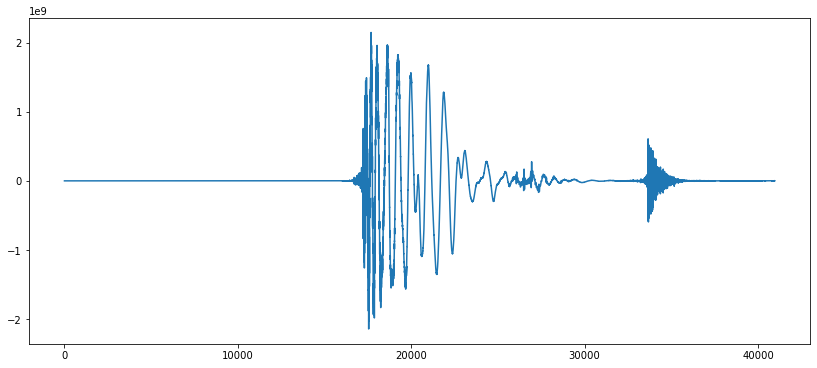

In [246]:
plt.figure(figsize=(14,6))
plt.plot([v for chunk in audio_data[:10] for v in chunk])
plt.show()

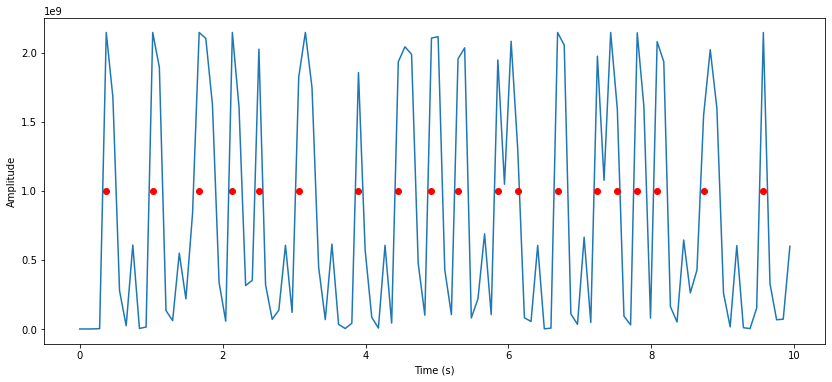

In [241]:
max_data = [np.max(r) for r in audio_data]
seconds = [(CHUNK / RATE)*i for i in range(len(audio_data))]

plot_time = 10 # seconds
amp_thresh = 1000000000

to_idx = np.where(np.array(seconds) > 10)[0][0] # Convert plot time in seconds to matching index
plt.figure(figsize=(14,6))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.plot(seconds[:to_idx], max_data[:to_idx])
plt.plot([seconds[i] for i, v in enumerate(abv_thresh[:to_idx]) if v == True], [amp_thresh for v in abv_thresh[:to_idx] if v == True], 'ro')
#plt.plot([seconds[i] for i, v in enumerate(max_data[:to_idx]) if v > amp_thresh], [v for v in max_data[:to_idx] if v > amp_thresh], 'ro')
plt.show()

In [119]:
ITERATION_CNT = 100

In [125]:
CHUNK = Audio.CHUNK
Audio.open_stream()
p = Audio.p
wf = Audio.wf
data = wf.readframes(CHUNK)

fifo_long = Audio.init_fifo_from_preprocessed_data(n_data, Audio.FIFO_LONG_LEN)
fifo_short = Audio.init_fifo_from_preprocessed_data(n_data, Audio.FIFO_SHORT_LEN)

for sample_idx in range(len(n_data)):
    Audio.stream.write(data)
    data = wf.readframes(CHUNK)
    if len(data) < CHUNK:
        break

    lfb = n_data[sample_idx]  # Log of the frequencies for each bucket

    # Get rolling average & min
    roll_delta, fifo_long, fifo_short = Audio.get_roll_delta(fifo_long, fifo_short, lfb)
    #print(np.max(roll_delta))
    if np.max(roll_delta) > 0.05:
        print(np.max(roll_delta))
#     if np.max(lfb) > .37:
#         print(np.max(lfb))
    
    if sample_idx > ITERATION_CNT:
        break

0.28232383811174633
0.28067861562765184
0.2871231352371697
0.165953011123337
0.06947503060844917
0.0700936876449415
0.0512624824058624
0.06825763548247693
0.05104003984281469
0.05647109632880443
0.050739618212251036
0.059356655242581546
0.06849665992491732


In [113]:
Audio.FIFO_LONG_LEN

20

In [114]:
Audio.FIFO_SHORT_LEN

1